# ASSR stimulus

In [ ]:
! pip install pyxdf
! pip install gdown

In [ ]:
import urllib.request
import numpy as np
import scipy
import os
import itertools
from scipy.io import wavfile
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pyxdf
from scipy.interpolate import interp1d
rng = np.random.default_rng(42)
plt.style.use('seaborn')

def write_file(file_content, file_path, flag='w+'):
  with open(file_path, flag) as fp:
    fp.write(file_content)

def write_url_content_to_file(url, file_path, flag='wb'):
  write_file(urllib.request.urlopen(url).read(), file_path, flag)


## Download and save pre-generated stimulus (Using Saurab's git repo as free static file server for the audio files. Use this sparely, I don't think github would like it when you use their service like that...)

In [ ]:
path_prefix = './' # On linux recommend using '/tmp/', since it is on RAM.
url_prefix ='https://github.com/SaurabSS/ASSRStimulus/raw/main/'
wav_names = ["a4-40", "b5-35", "cs6-75", "ds4-100", "f5-17", "g6-23"]
wav_urls = [f'{url_prefix}{name}.wav' for name in wav_names]
print(wav_urls)
wav_paths = [f'{path_prefix}{name}.wav' for name in wav_names]
Parallel(n_jobs=1)(delayed(write_url_content_to_file)(url, path) for url, path in zip(wav_urls, wav_paths))


['https://github.com/SaurabSS/ASSRStimulus/raw/main/a4-40.wav', 'https://github.com/SaurabSS/ASSRStimulus/raw/main/b5-35.wav', 'https://github.com/SaurabSS/ASSRStimulus/raw/main/cs6-75.wav', 'https://github.com/SaurabSS/ASSRStimulus/raw/main/ds4-100.wav', 'https://github.com/SaurabSS/ASSRStimulus/raw/main/f5-17.wav', 'https://github.com/SaurabSS/ASSRStimulus/raw/main/g6-23.wav']


[None, None, None, None, None, None]

## Visualize downloaded stimuli

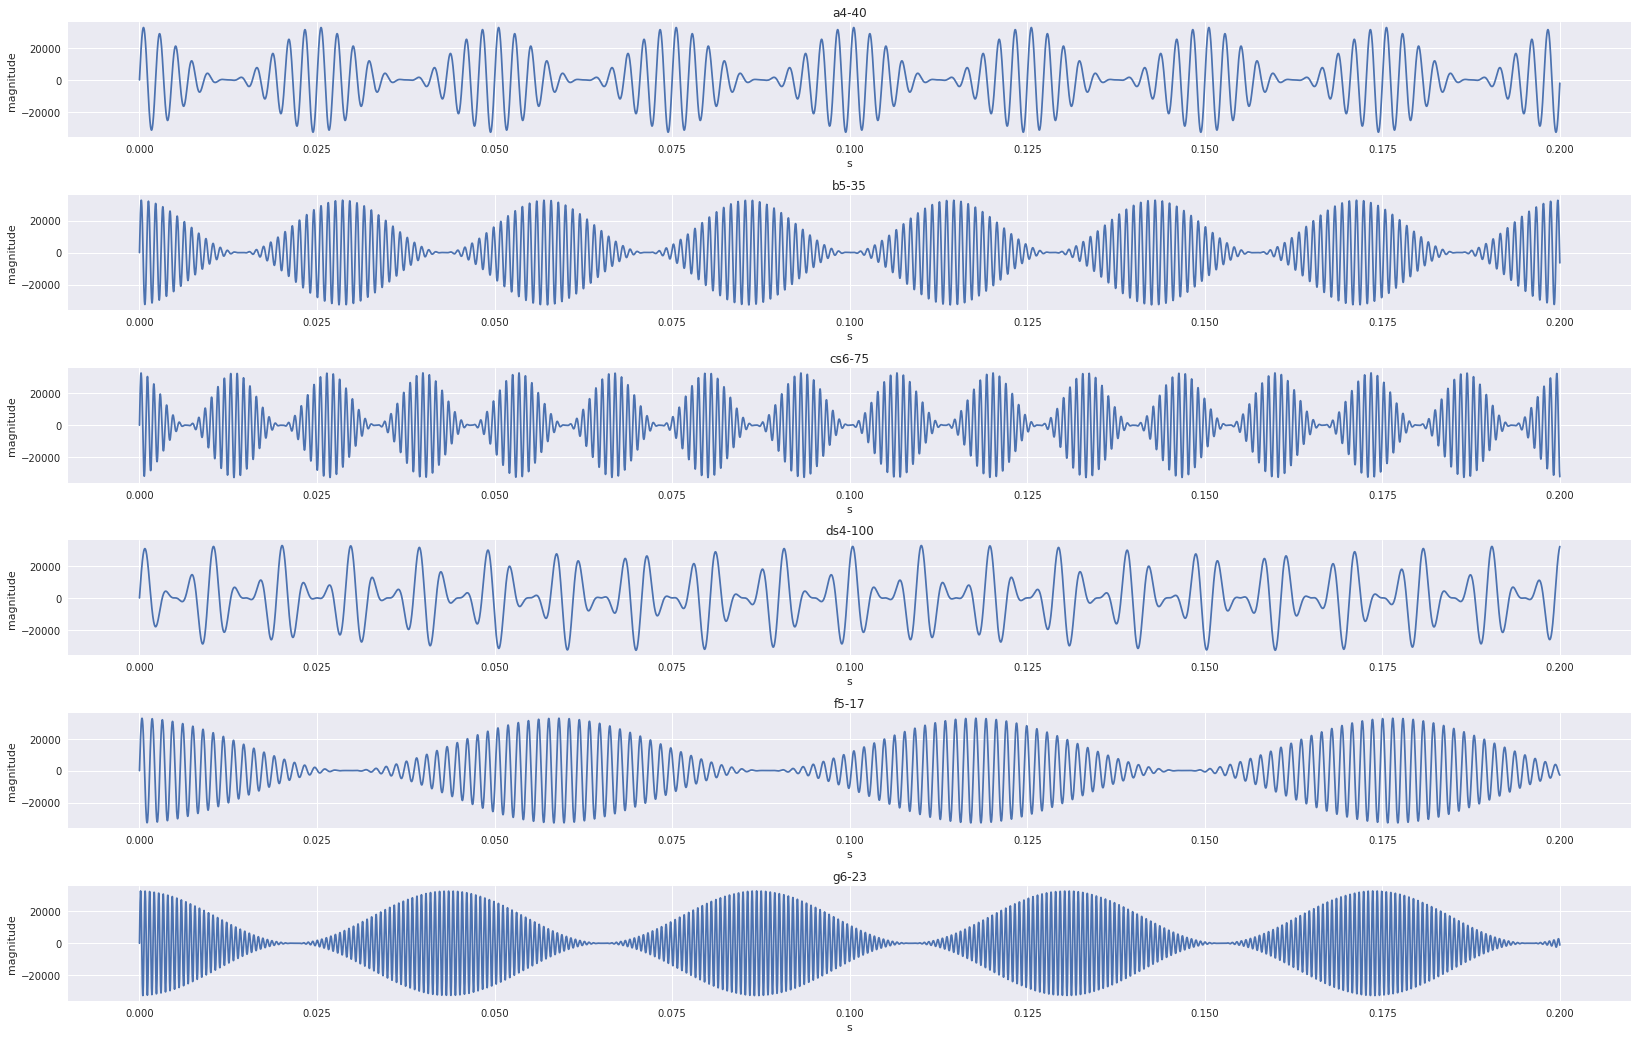

In [ ]:
fig = plt.figure(figsize=[28, 18])
for i, name, path in zip(range(len(wav_names)) , wav_names, wav_paths):
  # print(i, name, path)
  plt.subplot(len(wav_names), 1, i+1)
  rate, wav = wavfile.read(path)
  timestamp_s = np.linspace(0, len(wav)/rate, len(wav), endpoint=False)
  plot_range_index = int(rate / 5)
  plt.plot(timestamp_s[0:plot_range_index], wav[0:plot_range_index])
  plt.xlabel('s')
  plt.ylabel('magnitude')
  plt.title(name)
fig.subplots_adjust(hspace=0.5)
plt.show()


## Or generate your own stimuli

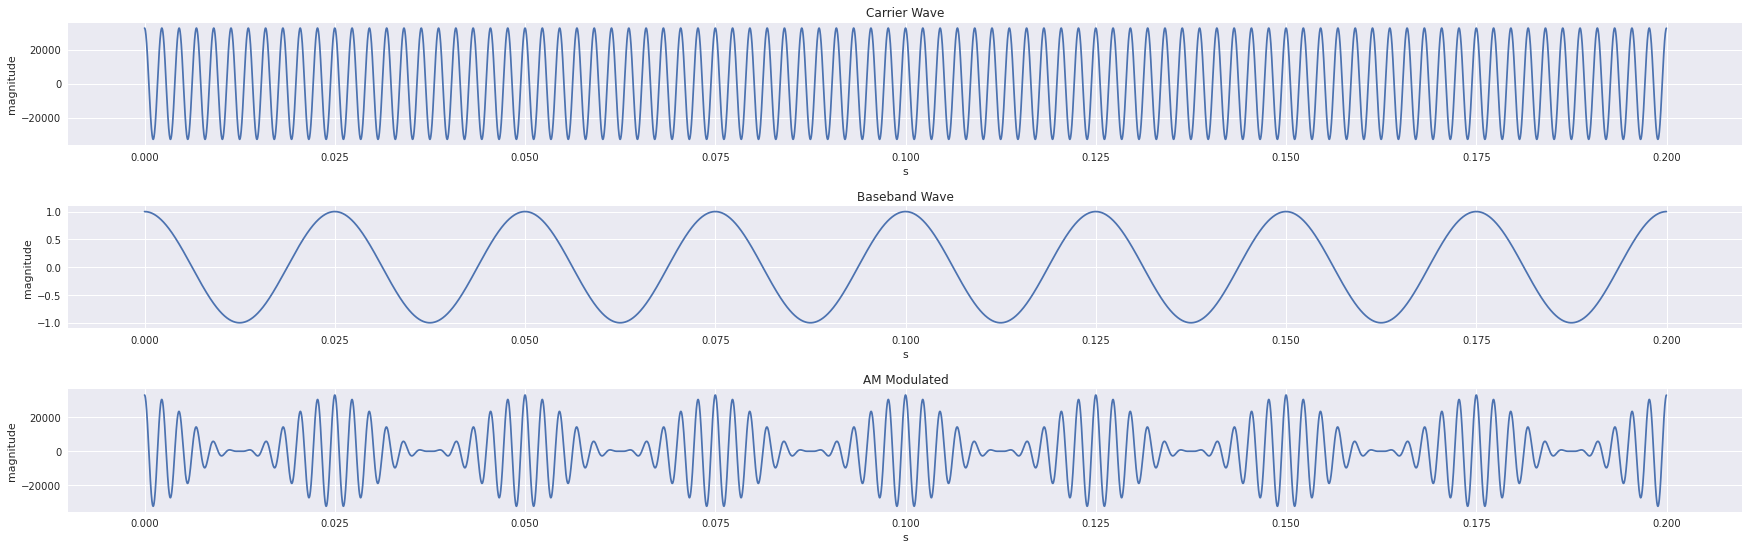

In [ ]:
stimulus_len_s = 10
sample_rate_Hz = 44100
carrier_dictionary_Hz = {
  'a4': 440.0,
  'b5': 987.77,
  'cs6': 1244.51,
  'ds4': 311.13,
  'f5': 698.46,
  'g6': 1567.98
} # s is # or sharp. e.g. cs6 == c#6
carrier_frequency = carrier_dictionary_Hz['a4']
baseband_frequency = 40
am_modifier = 0
data_len_num_frame = stimulus_len_s * sample_rate_Hz
samples = np.linspace(0, stimulus_len_s, int(data_len_num_frame), endpoint=False)
magnitude = 32767
mod_index = 1
carrier_signal = magnitude * np.cos( 2 * np.pi * carrier_frequency * samples)
baseband_signal = np.cos( 2 * np.pi * baseband_frequency * samples)
am_modulated = (1 + mod_index * baseband_signal) * carrier_signal / (1 + mod_index)

fig = plt.figure(figsize=(30, 9))
plot_range_index = int(sample_rate_Hz / 5)

plt.subplot(3, 1, 1)
plt.plot(samples[0: plot_range_index], carrier_signal[0: plot_range_index])
plt.title('Carrier Wave')
plt.xlabel('s')
plt.ylabel('magnitude')

plt.subplot(3, 1, 2)
plt.plot(samples[0: plot_range_index], baseband_signal[0: plot_range_index])
plt.title('Baseband Wave')
plt.xlabel('s')
plt.ylabel('magnitude')

plt.subplot(3, 1, 3)
plt.plot(samples[0: plot_range_index], am_modulated[0: plot_range_index])
plt.title('AM Modulated')
plt.xlabel('s')
plt.ylabel('magnitude')

fig.subplots_adjust(hspace=0.5)
plt.show()



## white noise

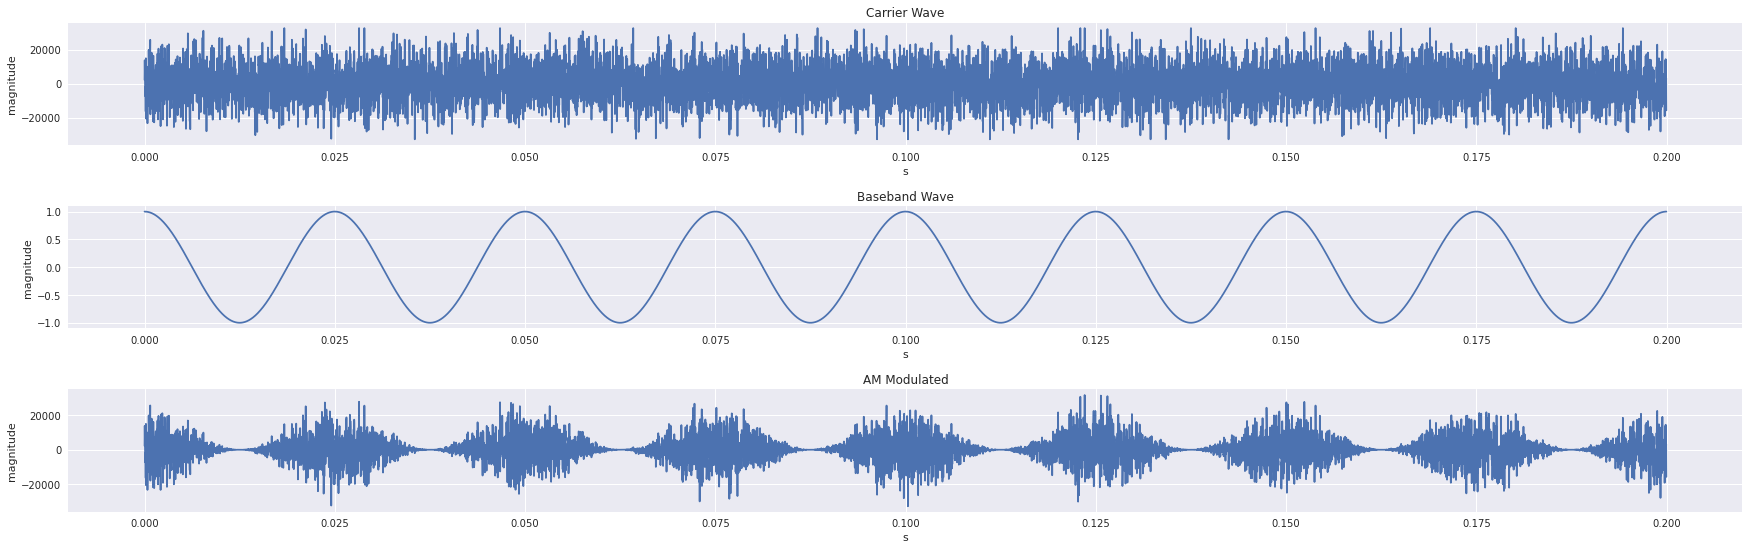

In [ ]:
white_noise_carrier = rng.normal(0, 32767 / 3, size=data_len_num_frame)
white_noise_carrier[white_noise_carrier > 32767] = 32767
white_noise_carrier[white_noise_carrier < -32767] = -32767
samples = np.linspace(0, stimulus_len_s, int(data_len_num_frame), endpoint=False)
baseband_signal = np.cos( 2 * np.pi * baseband_frequency * samples)
baseband_frequency = 40
mod_index = 1
am_modulated = (1 + mod_index * baseband_signal) * white_noise_carrier / (1 + mod_index)

fig = plt.figure(figsize=(30, 9))
plot_range_index = int(sample_rate_Hz / 5)

plt.subplot(3, 1, 1)
plt.plot(samples[0: plot_range_index], white_noise_carrier[0: plot_range_index])
plt.title('Carrier Wave')
plt.xlabel('s')
plt.ylabel('magnitude')

plt.subplot(3, 1, 2)
plt.plot(samples[0: plot_range_index], baseband_signal[0: plot_range_index])
plt.title('Baseband Wave')
plt.xlabel('s')
plt.ylabel('magnitude')

plt.subplot(3, 1, 3)
plt.plot(samples[0: plot_range_index], am_modulated[0: plot_range_index])
plt.title('AM Modulated')
plt.xlabel('s')
plt.ylabel('magnitude')

fig.subplots_adjust(hspace=0.5)
plt.show()

file_path = f'./white_noise-{baseband_frequency}.wav'
wavfile.write(file_path, sample_rate_Hz, am_modulated.astype(np.int16))


## Save generated one baseband stimuli

In [ ]:
stimulus_len_s = 10
sample_rate_Hz = 44100
carrier_names = ['a4', 'b5', 'cs6', 'ds4', 'f5', 'g6']
baseband_freqs_Hz = [40, 35, 75, 100, 17, 23]
# baseband_freqs_Hz = [40/2, 35/2, 75/2, 100/2, 17/2, 23/2]
generated_one_baseband_stimuli_path = './generated_one_baseband_stimuli'
generated_two_baseband_stimuli_path = './generated_two_baseband_stimuli'
if not os.path.exists(generated_one_baseband_stimuli_path):
  os.mkdir(generated_one_baseband_stimuli_path)
if not os.path.exists(generated_two_baseband_stimuli_path):
  os.mkdir(generated_two_baseband_stimuli_path)

one_baseband_am_modulated_wavs = []
for carrier_name, baseband_f_Hz in zip(carrier_names, baseband_freqs_Hz):
  carrier_f_Hz = carrier_dictionary_Hz[carrier_name]
  data_len_num_frame = stimulus_len_s * sample_rate_Hz
  samples = np.linspace(0, stimulus_len_s, int(data_len_num_frame), endpoint=False)
  carrier_signal = 32767 * np.sin( 2 * np.pi * carrier_f_Hz * samples)
  baseband_signal = np.sin( 2 * np.pi * baseband_f_Hz * samples)
  am_modulated = carrier_signal * baseband_signal
  one_baseband_am_modulated_wavs.append(am_modulated)
  save_file_path = f'{generated_one_baseband_stimuli_path}/{carrier_name}-{baseband_f_Hz}.wav'
  wavfile.write(save_file_path, sample_rate_Hz, am_modulated.astype(np.int16))

## Generate two baseband mixture tone and save

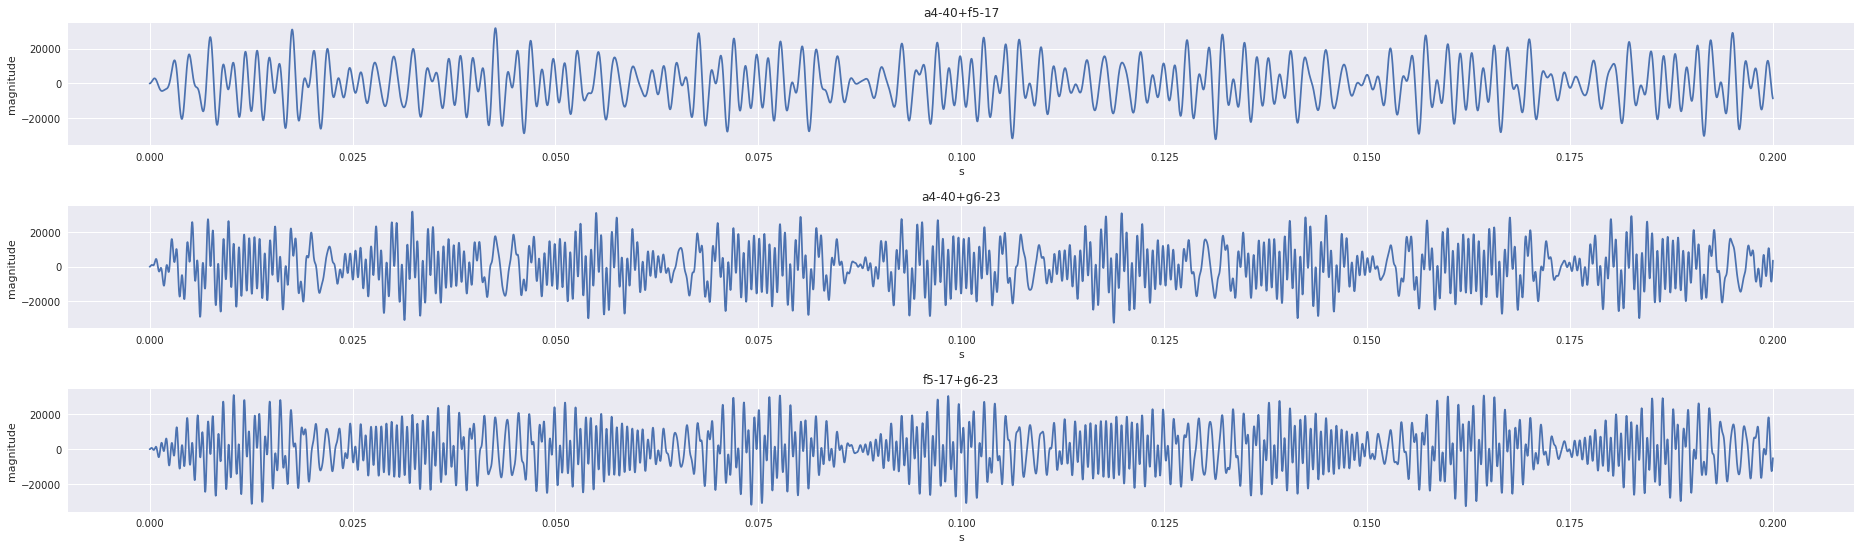

In [ ]:
selection_index = [0, 4, 5]
selection_permutations = list(itertools.combinations(selection_index, 2))
# print(selection_permutations)
mixed_tones = []
mixed_tones_names = []
mixed_tone_path_dict = {}
for i, tone_0_index_tone_1_index in enumerate(selection_permutations):
  tone_0_index, tone_1_index = tone_0_index_tone_1_index
  tone_0 = one_baseband_am_modulated_wavs[tone_0_index]
  tone_1 = one_baseband_am_modulated_wavs[tone_1_index]
  mixed_tone_0_1 = (tone_0 + tone_1) / 2
  mixed_tones.append(mixed_tone_0_1)
  name = f'{carrier_names[tone_0_index]}-{baseband_freqs_Hz[tone_0_index]}+{carrier_names[tone_1_index]}-{baseband_freqs_Hz[tone_1_index]}'
  mixed_tones_names.append(name)
  save_file_path = f'{generated_two_baseband_stimuli_path}/{name}.wav'
  wavfile.write(save_file_path, sample_rate_Hz, mixed_tone_0_1.astype(np.int16))
  mixed_tone_path_dict[tone_0_index_tone_1_index] = save_file_path

fig = plt.figure(figsize=(32, len(selection_permutations) * 3))
for i, mixed_tone in enumerate(mixed_tones):
  plt.subplot(len(selection_permutations), 1, i+1)
  mixed_tone_0_1 = mixed_tones[i]
  plt.plot(samples[0: plot_range_index], mixed_tone_0_1[0: plot_range_index])
  plt.title(mixed_tones_names[i])
  plt.xlabel('s')
  plt.ylabel('magnitude')

fig.subplots_adjust(hspace=0.5)
plt.show()

## Generate Experiment sequence 
 * Note that the order of presentation is random. Don't use the random function to generate the samples. Generate everything in non-random order and then randomly shuffle to make sure each item in the test has the same number

In [ ]:
num_repetition = 50
ref_mixture_seq = [j for i in [[(tone_1, (tone_1, tone_2)), (tone_2, (tone_1, tone_2))] for tone_1, tone_2 in selection_permutations] for j in i]
print(ref_mixture_seq)
ref_mixture_seq = np.array(ref_mixture_seq * 50, dtype=object)
print(ref_mixture_seq.tolist())
rng.shuffle(ref_mixture_seq)
print(mixed_tone_path_dict)

[(0, (0, 4)), (4, (0, 4)), (0, (0, 5)), (5, (0, 5)), (4, (4, 5)), (5, (4, 5))]
[[0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)], [5, (4, 5)], [0, (0, 4)], [4, (0, 4)], [0, (0, 5)], [5, (0, 5)], [4, (4, 5)

# Experiment Data file parsing
Tiny single baseband + 2 baseband mixture dataset: [link](https://drive.google.com/file/d/18DJo6_aNnAfmwNoDxFKmaKq1U6jo1FLY/view?usp=sharing) (id: 18DJo6_aNnAfmwNoDxFKmaKq1U6jo1FLY)

DON'T USE! BROKEN Tiny single baseband dataset Anna (83hz, 89Hz, 95Hz)[link](https://drive.google.com/file/d/1LUAi-SYaIjuw6isHo00WH5sc6grHjGgS/view?usp=sharing) (id: 1LUAi-SYaIjuw6isHo00WH5sc6grHjGgS)

Tiny single baseband dataset (83hz, 89Hz, 95Hz): [link](https://drive.google.com/file/d/13NOVgvX2ohO7C5kTlFI-h_YCzaFvihbY/view?usp=sharing) (id: 13NOVgvX2ohO7C5kTlFI-h_YCzaFvihbY)

Tiny single baseband dataset with OpenBCI (83hz, 89Hz, 95Hz): [link](https://drive.google.com/file/d/1KzWFU88NMAl5W_x5dEJEfaWWlQmV3dEF/view?usp=sharing) (id:1KzWFU88NMAl5W_x5dEJEfaWWlQmV3dEF)


Tiny single baseband dataset (40Hz. 17Hz, 23Hz): [link](https://drive.google.com/file/d/1EOPeldTLMe4AQkdXPb_joFFOq1dYS5TY/view?usp=sharing) (id: 1EOPeldTLMe4AQkdXPb_joFFOq1dYS5TY)

Big single baseband dataset (40Hz. 17Hz, 23Hz): [link](https://drive.google.com/file/d/1_Ov8rsDCGMqUEaR44-v8GlEYGGUN3vCt/view?usp=sharing)  (id: 1_Ov8rsDCGMqUEaR44-v8GlEYGGUN3vCt)

Tiny single baseband dataset (40Hz, 75Hz, 100Hz): [link](https://drive.google.com/file/d/1sV1BAzs6afKm9zRebAIjOfb-PPXk_Q5i/view?usp=sharing) (id: 1sV1BAzs6afKm9zRebAIjOfb-PPXk_Q5i)


In [ ]:
# !gdown --id 18DJo6_aNnAfmwNoDxFKmaKq1U6jo1FLY
# !gdown --id 13NOVgvX2ohO7C5kTlFI-h_YCzaFvihbY
# !gdown --id 1LUAi-SYaIjuw6isHo00WH5sc6grHjGgS
!gdown --id 1EOPeldTLMe4AQkdXPb_joFFOq1dYS5TY
# !gdown --id 1_Ov8rsDCGMqUEaR44-v8GlEYGGUN3vCt
# !gdown --id 1s6aiIZU8w-aiIVCnxULoPzbpfbubTE25
# !gdown --id 1KzWFU88NMAl5W_x5dEJEfaWWlQmV3dEF

Downloading...
From: https://drive.google.com/uc?id=1EOPeldTLMe4AQkdXPb_joFFOq1dYS5TY
To: /home/yuhui/projects/ASSRExperiment/sub-P001_ses-S001_task-Default_acq-one_baseband_Pz_ref_run-001_eeg.xdf
100%|██████████████████████████████████████| 6.16M/6.16M [00:00<00:00, 40.1MB/s]


In [ ]:
control_byte_dict = {
  'discard': 0,
  'quiet_period_start': 1,
  'quiet_period_end': 2,
  'one_tone_start': 3,
  'one_tone_end': 4,
  'two_tone_start': 5,
  'two_tone_end': 6
}

control_str = {val: key for key, val in control_byte_dict.items()}
# file_path = './sub-P001_ses-S001_task-Default_run-002_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_Pz_ref_high_freq_run-001_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_run-005_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_run-008_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_run-007_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_Pz_ref_run-001_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_Pz_ref_high_freq_run-001_eeg.xdf'
# file_path = './sub-P002_ses-S001_task-Default_acq-pz_ref_high_freq_run-001_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-stock_OPenBCI_high_freq_PZ_ref_run-001_eeg.xdf'
# file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_Pz_ref_high_freq_run-001_eeg.xdf'
file_path = './sub-P001_ses-S001_task-Default_acq-one_baseband_Pz_ref_run-001_eeg.xdf'
data, header = pyxdf.load_xdf(file_path)
data_stream_name_to_ind = {d['info']['name'][0]: i for i, d in enumerate(data)}
eeg_data_i = data_stream_name_to_ind['obci_eeg1']
stimulus_label_i = data_stream_name_to_ind['stimulusStream']
eeg_data = data[eeg_data_i]
stimulus_label = data[stimulus_label_i]
eeg_timeseries = eeg_data['time_series']
eeg_timestamps = eeg_data['time_stamps']
stimulus_timeseries = stimulus_label['time_series']
stimulus_timestamps = stimulus_label['time_stamps']
stimulus_type_ts = [i[0] >> 16 for i in stimulus_timeseries]
stimulus_str_ts = [control_str[i] for i in stimulus_type_ts]
stimulus_one_tone_label_ts = [(i[0] & 0x0000ff00) >> 8 for i in stimulus_timeseries]
stimulus_two_tone_label_ts = [(i[0] & 0x000000ff) for i in stimulus_timeseries]
print(stimulus_type_ts)
# print(stimulus_one_tone_label_ts)
# print(stimulus_two_tone_label_ts)
quiet_period_data_index_tuple = [0, 0]
one_baseband_data_index_tuple = []
one_baseband_data_label = []
two_baseband_data_index_tuple = []
two_baseband_data_focus_label = []
two_baseband_data_tuple_label = []
i = 0
while i < len(stimulus_timeseries):
  if stimulus_type_ts[i] == 1:
    index = np.sum(eeg_timestamps < stimulus_timestamps[i]) + 1
    print(stimulus_timestamps[i])
    quiet_period_data_index_tuple[0] = index
  elif stimulus_type_ts[i] == 2:
    index = np.sum(eeg_timestamps < stimulus_timestamps[i]) - 1
    print(stimulus_timestamps[i])
    quiet_period_data_index_tuple[1] = index
  elif stimulus_type_ts[i] == 3:
    if (i + 4 < len(stimulus_timeseries)):
      if stimulus_type_ts[i + 4] == 0:
        i += 5
        continue
    one_baseband_data_index_tuple.append([])
    one_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i] + 0.5)) + 1)
    one_baseband_data_label.append(stimulus_one_tone_label_ts[i])
    pass
  elif stimulus_type_ts[i] == 4:
    one_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i] - 0.5)) - 1)
    pass
  elif stimulus_type_ts[i] == 5:
    two_baseband_data_index_tuple.append([])
    two_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i] + 0.5)) + 1)
    two_baseband_data_tuple_label.append((stimulus_one_tone_label_ts[i], stimulus_two_tone_label_ts[i]))
    two_baseband_data_focus_label.append(one_baseband_data_label[-1])
    pass
  elif stimulus_type_ts[i] == 6:
    two_baseband_data_index_tuple[-1].append(np.sum(eeg_timestamps < (stimulus_timestamps[i] - 0.5)) - 1)
    pass
  i += 1

# print(quiet_period_data_index_tuple)

# print(valid_mask)
print(quiet_period_data_index_tuple)
# index_offset = quiet_period_data_index_tuple[0]
index_offset = 0
eeg_timeseries = eeg_timeseries[index_offset:, :]
valid_mask = np.array([len(i) == 2 for i in one_baseband_data_index_tuple])
one_baseband_data_index_tuple = [i_tuple for i_tuple, is_valid in zip(one_baseband_data_index_tuple, valid_mask) if is_valid]
one_baseband_data_label = [label for label, is_valid in zip(one_baseband_data_label, valid_mask) if is_valid]
one_baseband_data_index_tuple = [(t[0] - index_offset, t[1] - index_offset) for t in one_baseband_data_index_tuple]
two_baseband_data_index_tuple = [(t[0] - index_offset, t[1] - index_offset) for t in two_baseband_data_index_tuple]
print(one_baseband_data_index_tuple)
print(two_baseband_data_index_tuple)
print(two_baseband_data_tuple_label)
print(two_baseband_data_focus_label)
print(data[0]['info'])
print(data[1]['info'])
print(len(one_baseband_data_label))

[1, 2, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4]
1634088356.6123755
1634088386.6125205
[3162, 10663]
[(11422, 12046), (12682, 13306), (13941, 14565), (15201, 15825), (16461, 17085), (17721, 18345), (18981, 19605), (20241, 20864), (21500, 22124), (22760, 23384), (24020, 24644), (25280, 25904), (26540, 27164), (27799, 2842

## Data sanity check!

(164810, 8)
[624, 624, 624, 624, 624, 624, 624, 623, 624, 624, 624, 624, 624, 624, 624, 624, 624, 623, 625, 624, 624, 624, 624, 624, 624, 624, 624, 623, 624, 624, 624, 624, 623, 623, 625, 624, 624, 624, 624, 623, 624, 624, 624, 624, 624, 624, 625, 624, 623, 624, 623, 624, 624, 623, 624, 623, 624, 624, 624, 624, 623, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 623, 625, 624, 623, 624, 624, 624, 624, 623, 624, 623, 624, 624, 624, 624, 623, 624, 624, 624, 624, 624, 623, 623, 624, 624, 624, 623, 624, 625, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 623, 624, 624, 625, 624, 624, 624, 624]
(164810,)


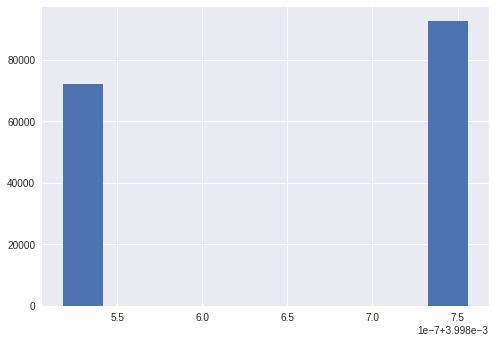

In [ ]:
print(eeg_timeseries.shape)
print([tuple_pair[1] - tuple_pair[0] for tuple_pair in one_baseband_data_index_tuple])
print(eeg_timestamps.shape)
d_timestamp = eeg_timestamps[1:] - eeg_timestamps[0:-1]
fig = plt.figure()
plt.hist(d_timestamp)
plt.show()

WTF is wrong with the timestamps!


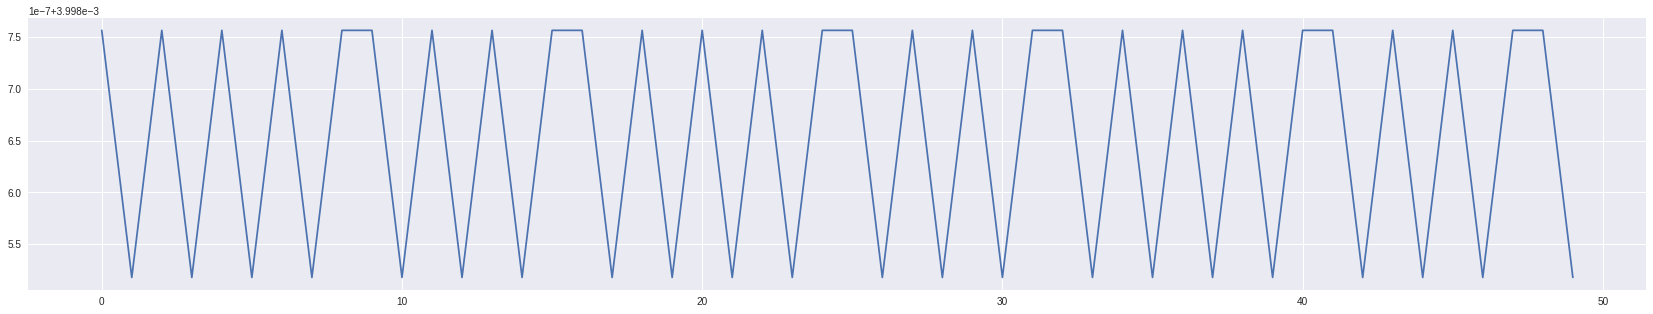

In [ ]:
print('WTF is wrong with the timestamps!')
fig = plt.figure(figsize=(29, 5))
plt.plot(d_timestamp[0:50])
plt.show()


## Data Filtering

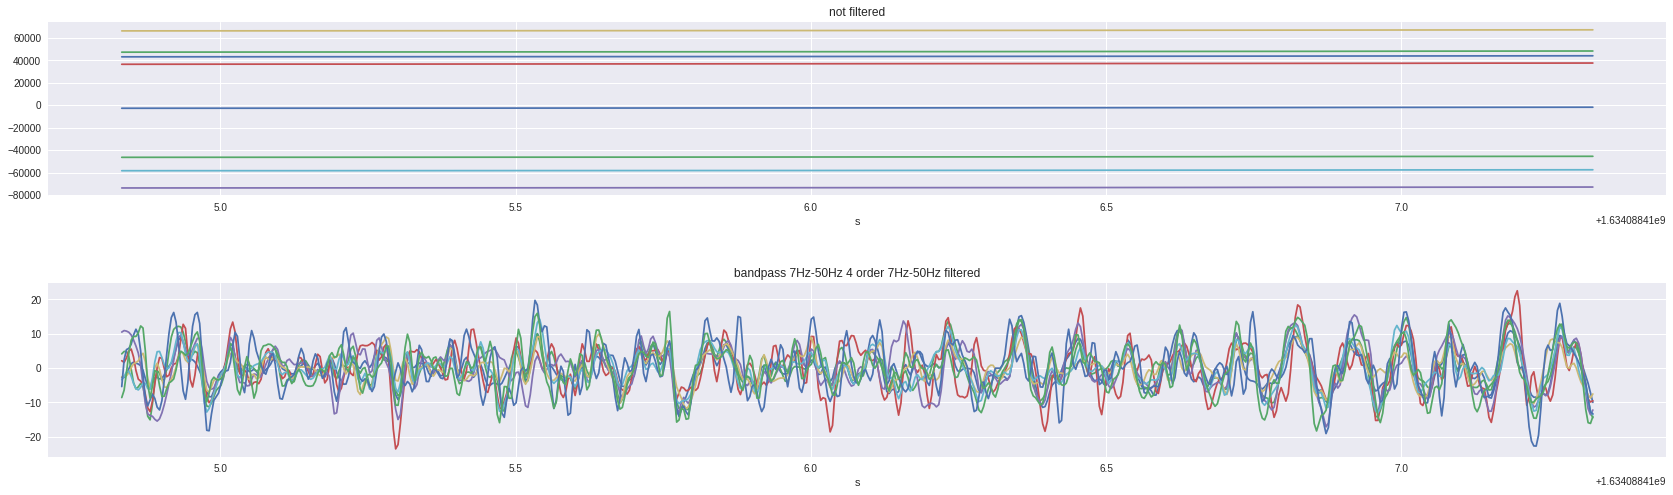

In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut=5, highcut=50, fs=250, order=4):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, axis=0, order=4):
  sos = butter_bandpass(lowcut, highcut, fs, order=order)
  y = sosfilt(sos, data, axis=axis)
  return y

frequency_choices = np.unique(one_baseband_data_label)

bandpass_low = frequency_choices.min() - 10
bandpass_high = frequency_choices.max() + 10
# bandpass_low = 5
# bandpass_high = 120
bandpass_order = 4
eeg_timeseries_filtered = butter_bandpass_filter(eeg_timeseries, bandpass_low, bandpass_high, 250, order=bandpass_order)

# eeg_timeseries_filtered = eeg_timeseries
# print(eeg_timeseries_filtered.shape)
channels = [0, 1, 2, 3, 4, 5, 6, 7]
trial_index = 5
fig = plt.figure(figsize=(29, 8))
plt.subplot(2, 1, 1)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1]], eeg_timeseries[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1], channels])
plt.title('not filtered')
plt.xlabel('s')
plt.subplot(2, 1, 2)
plt.plot(eeg_timestamps[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1]], eeg_timeseries_filtered[one_baseband_data_index_tuple[trial_index][0]: one_baseband_data_index_tuple[trial_index][1], channels])
plt.title(f'bandpass {bandpass_low}Hz-{bandpass_high}Hz {bandpass_order} order {bandpass_low}Hz-{bandpass_high}Hz filtered')
plt.xlabel('s')

fig.subplots_adjust(hspace=0.5)
plt.show()

## Raw data each channel visualization

(164810, 8)


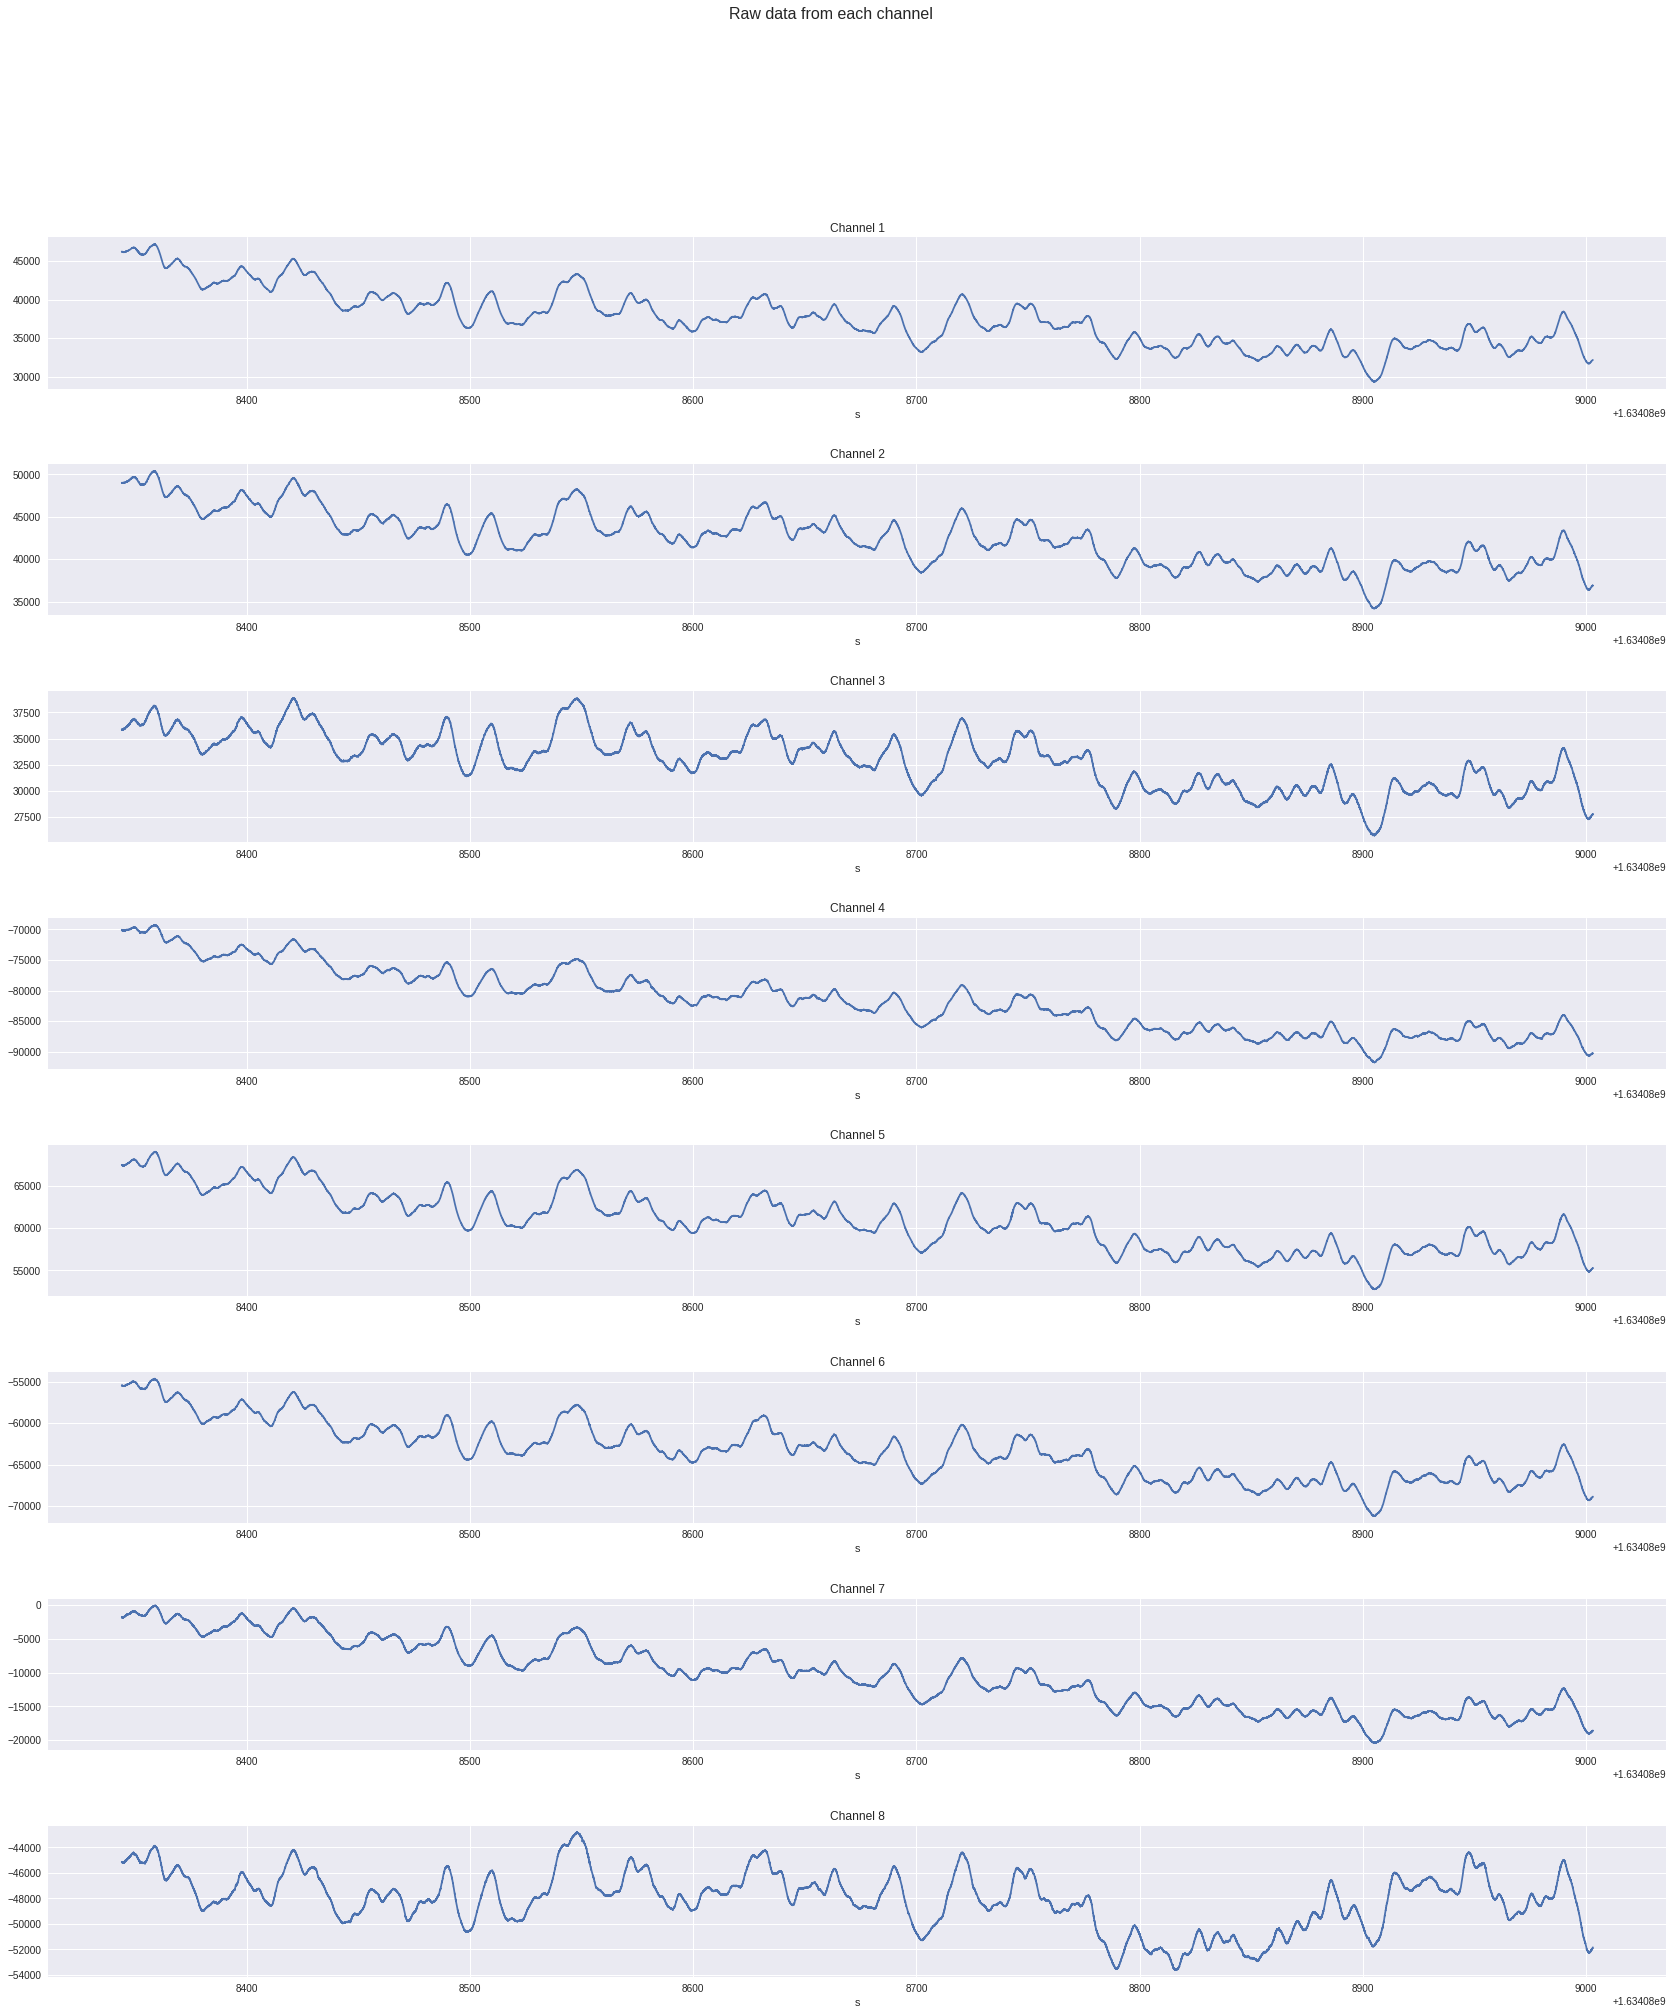

In [ ]:
print(eeg_timeseries.shape)
fig = plt.figure(figsize=(29, 32))
fig.suptitle('Raw data from each channel',fontsize=16)
fig.subplots_adjust(hspace=0.5)
for i in range(eeg_timeseries.shape[1]):
  plt.subplot(8, 1, i+1)
  plt.plot(eeg_timestamps, eeg_timeseries[:, i])
  plt.xlabel('s')
  plt.title(f'Channel {i+1}')

plt.show()

## Filtered data each channel visualization

(164810, 8)


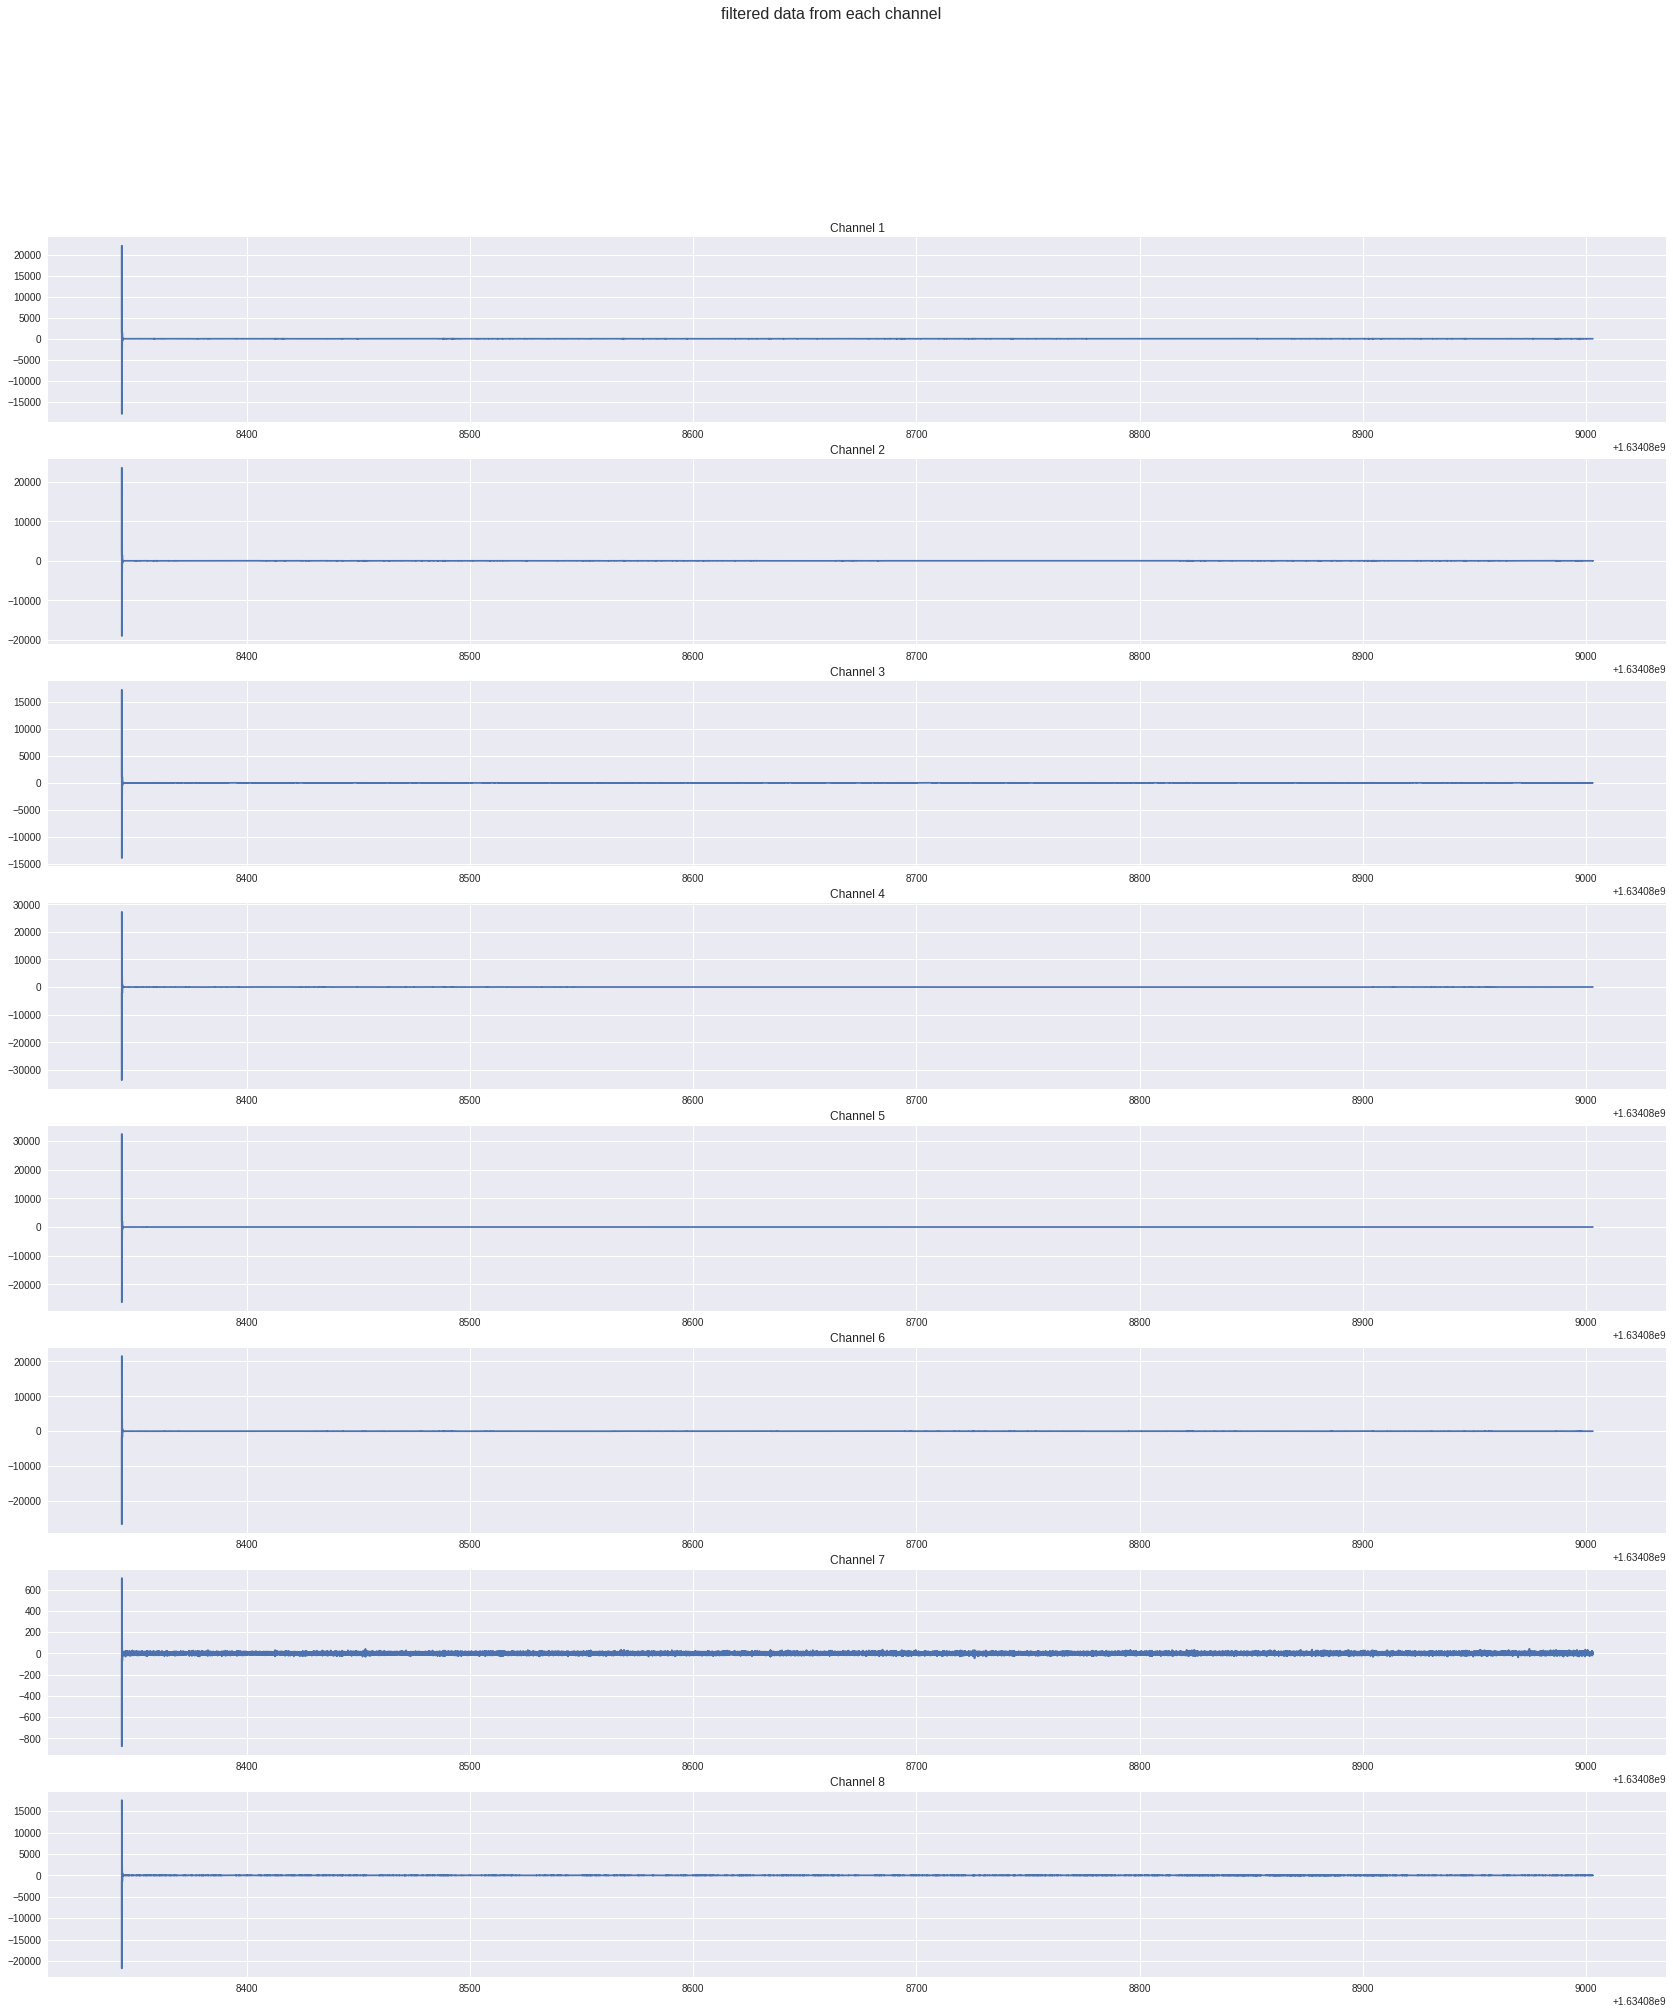

In [ ]:
print(eeg_timeseries_filtered.shape)
fig = plt.figure(figsize=(29, 32))
fig.suptitle('filtered data from each channel',fontsize=16)
for i in range(eeg_timeseries_filtered.shape[1]):
  plt.subplot(8, 1, i+1)
  plt.plot(eeg_timestamps, eeg_timeseries_filtered[:, i])
  plt.title(f'Channel {i+1}')

plt.show()

In [ ]:
print(np.unique(one_baseband_data_label))
print(eeg_timeseries_filtered.shape)
print(one_baseband_data_index_tuple)

[17 23 40]
(164810, 8)
[(11422, 12046), (12682, 13306), (13941, 14565), (15201, 15825), (16461, 17085), (17721, 18345), (18981, 19605), (20241, 20864), (21500, 22124), (22760, 23384), (24020, 24644), (25280, 25904), (26540, 27164), (27799, 28423), (29059, 29683), (30319, 30943), (31579, 32203), (32839, 33462), (34098, 34723), (35358, 35982), (36618, 37242), (37878, 38502), (39138, 39762), (40398, 41022), (41657, 42281), (42917, 43541), (44177, 44801), (45437, 46060), (46697, 47321), (47956, 48580), (49216, 49840), (50476, 51100), (51736, 52359), (52996, 53619), (54255, 54880), (55515, 56139), (56775, 57399), (58035, 58659), (59295, 59919), (60555, 61178), (61814, 62438), (63074, 63698), (64334, 64958), (65594, 66218), (66854, 67478), (68113, 68737), (69373, 69998), (70633, 71257), (71893, 72516), (73153, 73777), (74413, 75036), (75672, 76296), (76932, 77556), (78192, 78815), (79452, 80076), (80712, 81335), (81971, 82595), (83231, 83855), (84491, 85115), (85751, 86375), (87011, 87634), 

## Throw away trials with large artifects
 1. get energy distribution for each channel.
 2. Set threshold for outliners.
 3. Throw away outliners


[ 8263.7263701  12716.93697481 23634.09253811 20118.77125101
  8559.55519475 13027.18833896 34785.79975473 21512.11719345] [1706.67270333 2508.370273   3542.77426731 3219.17317466 1734.27977351
 2193.41367888 3691.21471028 3529.4994835 ]


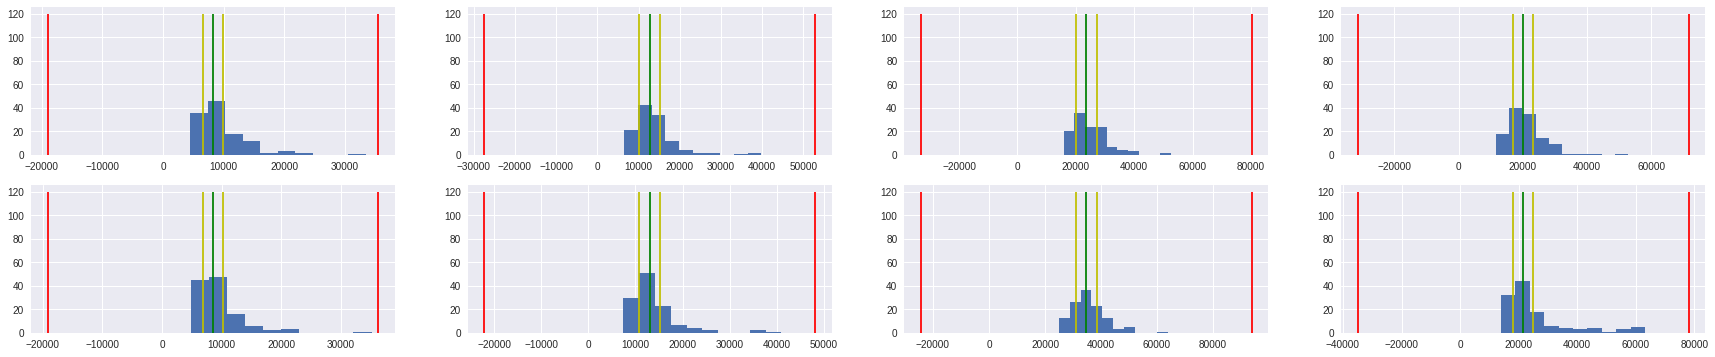

In [ ]:
energy = np.zeros((len(one_baseband_data_label), eeg_timeseries.shape[1]))
n_mad = 16
for win_i, label, start_index_end_index in zip(range(len(one_baseband_data_label)), one_baseband_data_label, one_baseband_data_index_tuple):
  start_index, end_index = start_index_end_index
  filtered_data_win = eeg_timeseries_filtered[start_index: end_index, :]
  energy[win_i, :] = np.power(filtered_data_win, 2).sum(axis=0)

energy_median = np.median(energy, axis=0)
energy_mad = scipy.stats.median_abs_deviation(energy, axis=0)
print(energy_median, energy_mad)

fig = plt.figure(figsize=(30, 6))
for i in range(eeg_timeseries.shape[1]):
  plt.subplot(2, 4, i+1)
  plt.hist(energy[:, i])
  plt.vlines([energy_median[i], energy_median[i] - energy_mad[i], energy_median[i] + energy_mad[i], energy_median[i] - n_mad * energy_mad[i], energy_median[i] + n_mad * energy_mad[i]], ymin=0, ymax=len(one_baseband_data_label), colors=['g', 'y', 'y', 'r', 'r'])

In [ ]:
print(energy.shape)
lower_valid_val  = np.ones((len(one_baseband_data_label), 1)) @ np.expand_dims(energy_median - n_mad * energy_mad, 0)
higher_valid_val = np.ones((len(one_baseband_data_label), 1)) @ np.expand_dims(energy_median + n_mad * energy_mad, 0)
valid_mask = np.all( (energy >= lower_valid_val) & (energy <= higher_valid_val), axis=1)
print(valid_mask.shape)
print(valid_mask.sum())
# print(np.all(energy>lower_valid_val, axis=1).sum())
# valid_window_mask = np.logical_and(, axis=0)
# print(valid_window_mask.shape)
# print(np.logical_not(valid_mask))
# one_baseband_data_label[] = -1
frequency_choices = np.unique(one_baseband_data_label)
one_baseband_data_label = np.array(one_baseband_data_label)
one_baseband_data_label[np.logical_not(valid_mask)] = -1

NameError: ignored

## FFT

FFT resolution: 0.5 Hz


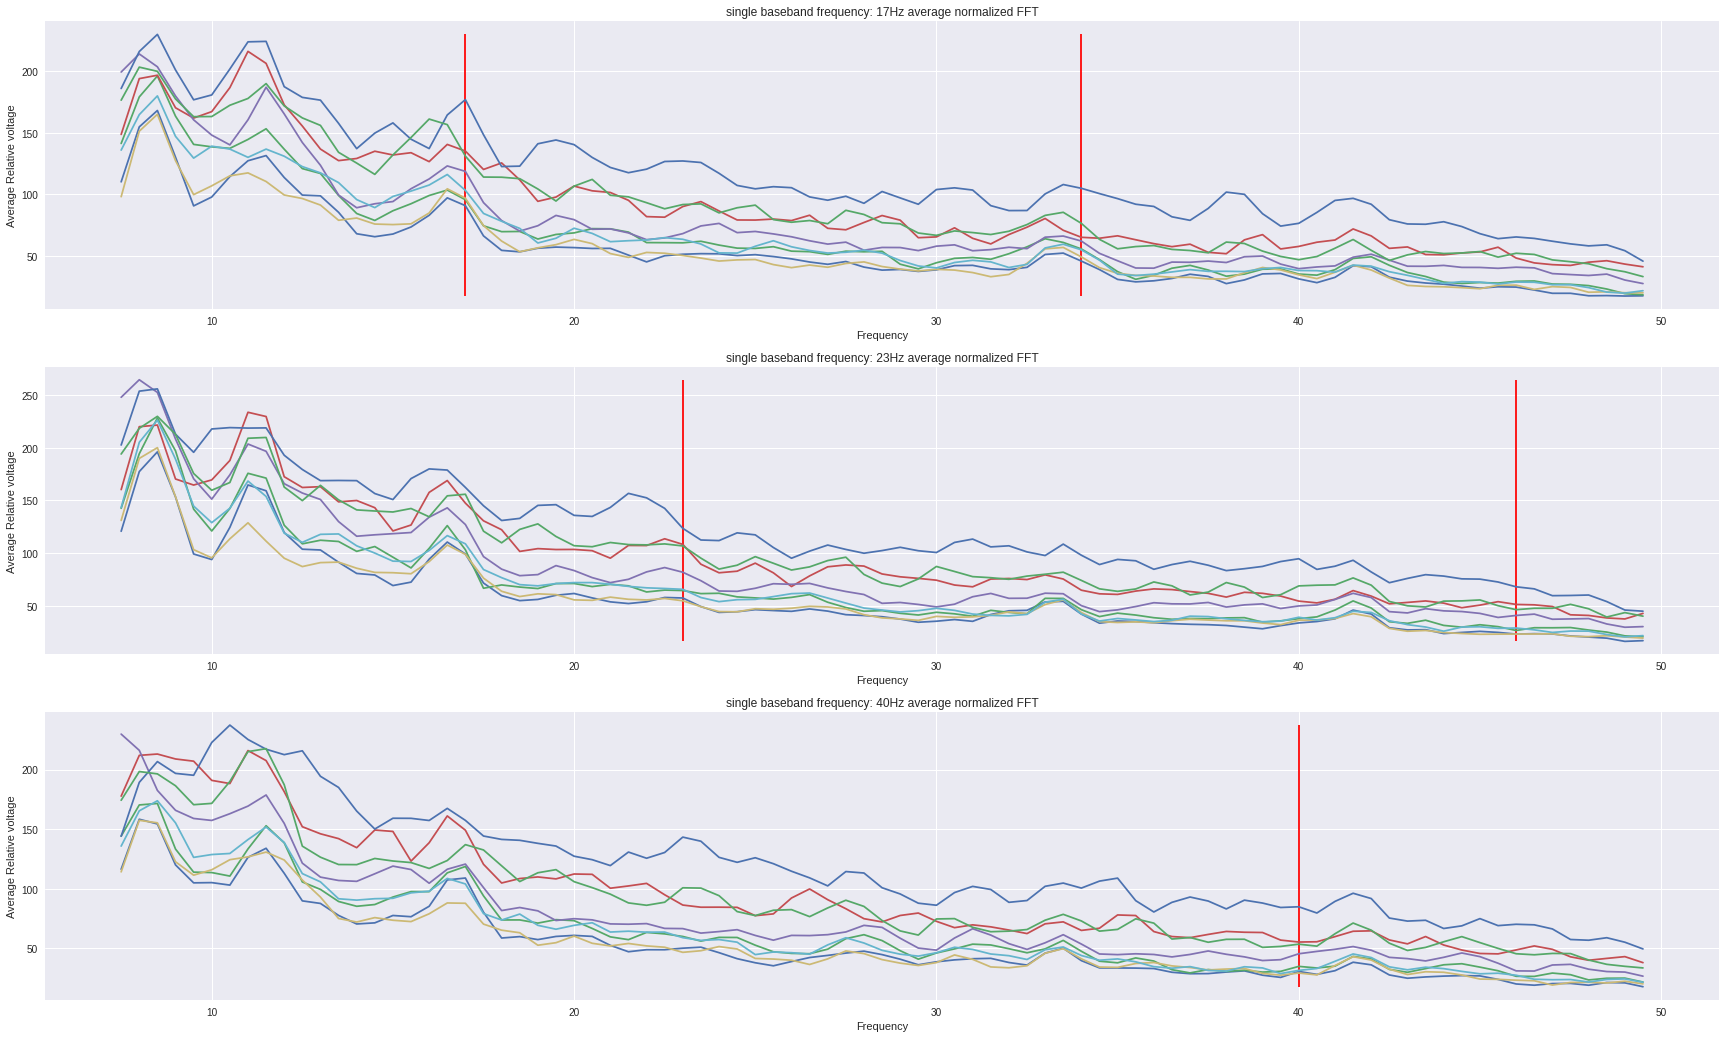

In [ ]:
from scipy.fft import fft, fftfreq
fft_win = 500
SAMPLE_RATE = 250
DURATION_S = fft_win / 250
DELAY_S = 0.25
DELAY_FRAME = int(SAMPLE_RATE * DELAY_S)
N = fft_win
xf = fftfreq(N, 1 / SAMPLE_RATE)
xf_mask = (xf > bandpass_low) & (xf < bandpass_high)
# xf_mask = (xf > bandpass_low) & (xf < 60)
# print(xf_mask)
selected_xf = xf[xf_mask]
print(f'FFT resolution: {np.mean(selected_xf[1:] - selected_xf[0:-1])} Hz')
fig = plt.figure(figsize=(30, 18))
# window = scipy.signal.windows.hamming(fft_win).reshape((fft_win, 1))
# window = scipy.signal.windows.hann(fft_win).reshape((fft_win, 1))
window = scipy.signal.windows.blackmanharris(fft_win, False).reshape((fft_win, 1))
# window = np.ones(fft_win).reshape((fft_win, 1))
# channels = [0, 1, 2, 3, 4, 5, 6, 7]
channels = [0]
for choice_i, baseband_freq in enumerate(frequency_choices):
  one_baseband_mask = one_baseband_data_label == baseband_freq
  one_baseband_tuples = np.array(one_baseband_data_index_tuple, dtype=object)[one_baseband_mask]
  one_baseband_windows = []
  for start_index, end_index in one_baseband_tuples:
    windows = []
    current_frame = start_index
    while (current_frame + fft_win + DELAY_FRAME) < end_index:
      windows.append(eeg_timeseries_filtered[current_frame + DELAY_FRAME: current_frame + DELAY_FRAME + fft_win])
      current_frame += fft_win
    one_baseband_windows += windows

  one_baseband_windows = [np.array(win) * window for win in one_baseband_windows]

  window_ffts = []

  for win in one_baseband_windows:
    window_ffts.append(np.abs(fft(win, axis=0)))

  # window_ffts = np.array([fft_result for fft_result in window_ffts])
  # window_ffts_normalize = np.array([ np.mean(win / np.sum(win, axis=0), axis=1) for win in window_ffts])

  # For each channel, get the spectrum density as a form of normalization
  # window_ffts_normalize = np.array([ np.mean(win[:, channels] / np.sum(win[:, channels], axis=0), axis=1) for win in window_ffts])
  window_ffts_normalize = np.array(window_ffts)

  df_avg_window_ffts = np.mean(window_ffts_normalize, axis=0)
  plt.subplot(3, 1, choice_i + 1)
  masked_fft = df_avg_window_ffts[xf_mask]
  plt.plot(xf[xf_mask], masked_fft)
  baseband_freq_and_harmonics = np.array([1, 2, 3, 4, 5]) * baseband_freq
  baseband_freq_and_harmonics = baseband_freq_and_harmonics[baseband_freq_and_harmonics < bandpass_high]
  plt.vlines(baseband_freq_and_harmonics, np.min(masked_fft), np.max(masked_fft), colors='red')
  plt.title(f'single baseband frequency: {baseband_freq}Hz average normalized FFT')
  plt.xlabel('Frequency')
  plt.ylabel('Average Relative voltage')


plt.show()